In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoModel
from tqdm import tqdm
import os

In [ ]:
base_dir    = '/content/drive/MyDrive/Datasets/'
train_path  = os.path.join(base_dir, 'train-ekphrasis.csv')
test_path    = os.path.join(base_dir, 'test-ekphrasis.csv')
MAX_LENGTH  = 32
MODEL       = 'cardiffnlp/twitter-roberta-base-sentiment'
MODEL_NAME  = 'text-part'
N_LABELS    = 1

In [ ]:
df_train = pd.read_csv(train_path)

In [ ]:
print(df_train.shape)

(14277, 9)


In [ ]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
 7   CleanText   14277 non-null  object
 8   enc_label   14277 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1004.0+ KB
None


In [ ]:
display(df_train.head())

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,CleanText,enc_label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,Do you remember the movie: “The day after tomo...,1
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,@milenagimon: Look at Sandy in NY! Tremendous ...,1
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,"Good photo of Hurricane Sandy, it reminds me o...",1
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,Scary shit #hurricane #NY http://t.co/e4JLBUfH,1
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,My fave place in the world #nyc #hurricane #sa...,1


In [ ]:
df_test = pd.read_csv(test_path)

In [ ]:
print(df_test.shape)

(3755, 9)


In [ ]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
 7   CleanText   3755 non-null   object
 8   enc_label   3755 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 264.1+ KB
None


In [ ]:
display(df_test.head())

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,CleanText,enc_label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake,kereeen RT @Shyman33: Eclipse from ISS.... htt...,1
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake,Absolutely beautiful! RT @Shyman33: Eclipse fr...,1
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake,“@Shyman33: Eclipse from ISS.... http://t.co/C...,1
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake,Eclipse from ISS.... http://t.co/En87OtvsU6,1
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake,@ebonfigli: Eclipse seen from the ISS... Anoth...,1


In [ ]:
df_train.rename(columns = {"imageId(s)":"images"}, inplace = True)
df_test.rename(columns = {"imageId(s)":"images"}, inplace = True)
df_train.drop(labels=['tweetId','userId', 'username', 'timestamp'], axis = 'columns', inplace = True)
df_test.drop(labels=['tweetId','userId', 'username', 'timestamp'], axis = 'columns', inplace = True)

In [ ]:
df_train.head()

,tweetText,images,label,CleanText,enc_label
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,fake,Do you remember the movie: “The day after tomo...,1
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,fake,@milenagimon: Look at Sandy in NY! Tremendous ...,1
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,fake,"Good photo of Hurricane Sandy, it reminds me o...",1
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,fake,Scary shit #hurricane #NY http://t.co/e4JLBUfH,1
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,fake,My fave place in the world #nyc #hurricane #sa...,1


In [ ]:
df_test.head()

,tweetText,images,label,CleanText,enc_label
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,fake,kereeen RT @Shyman33: Eclipse from ISS.... htt...,1
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,fake,Absolutely beautiful! RT @Shyman33: Eclipse fr...,1
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,fake,“@Shyman33: Eclipse from ISS.... http://t.co/C...,1
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,fake,Eclipse from ISS.... http://t.co/En87OtvsU6,1
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,fake,@ebonfigli: Eclipse seen from the ISS... Anoth...,1


fake labels count in training dataset:  6742
humor labels count in training dataset:  2614
real labels count in training dataset:  4921
---------------------------------------------
fake labels count in testing dataset:  2546
humor labels count in testing dataset:  0
real labels count in testing dataset:  1209


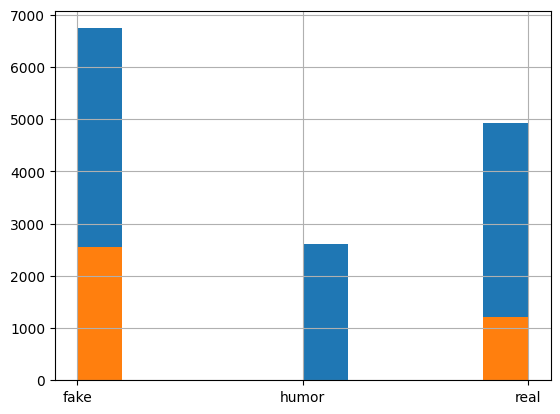

In [ ]:
training_fake_labels_count = (df_train.label=='fake').sum()
training_humor_labels_count = (df_train.label=='humor').sum()
training_real_labels_count = (df_train.label=='real').sum()
print('fake labels count in training dataset: ',training_fake_labels_count)
print('humor labels count in training dataset: ',training_humor_labels_count)
print('real labels count in training dataset: ',training_real_labels_count)
training_hist = df_train['label'].hist()
print("-"*45)
testing_fake_labels_count = (df_test.label=='fake').sum()
testing_humor_labels_count = (df_test.label=='humor').sum()
testing_real_labels_count = (df_test.label=='real').sum()
print('fake labels count in testing dataset: ', testing_fake_labels_count)
print('humor labels count in testing dataset: ', testing_humor_labels_count)
print('real labels count in testing dataset: ', testing_real_labels_count)
testing_hist = df_test['label'].hist()

In [ ]:
# Get the lists of sentences and their labels.
train_sent      = df_train.CleanText.values
train_labels    = df_train.enc_label.values
test_sent        = df_test.CleanText.values
test_labels      = df_test.enc_label.values

In [ ]:
#Bertweet tokens
import re

for i in range(train_sent.shape[0]):
    train_sent[i] = re.sub(r'<url>','HTTPURL',train_sent[i])
    train_sent[i] = re.sub(r'<user>','@USER',train_sent[i])
for i in range(test_sent.shape[0]):
    test_sent[i] = re.sub(r'<url>','HTTPURL',test_sent[i])
    test_sent[i] = re.sub(r'<user>','@USER',test_sent[i])

In [ ]:
# Load the RoBERTa tokenizer.
print('Loading RoBERTa tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case=False)

Loading RoBERTa tokenizer...


In [ ]:
text_model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_len = 0
stat = []
for sent in tqdm(train_sent):
    input_ids   = tokenizer.encode(sent, add_special_tokens=True)
#    if(len(input_ids)>96):
#      print(sent)
    max_len     = max(max_len, len(input_ids))
    stat.append(len(input_ids))

print('\nMax sentence length in train data: ', max_len)

# for sent in tqdm(val_sent):
#     input_ids   = tokenizer.encode(sent, add_special_tokens=True)
#  #   if(len(input_ids)>96):
#  #     print(sent)
#     max_len     = max(max_len, len(input_ids))
#     stat.append(len(input_ids))

# print('\nMax sentence length in both train and val data: ', max_len)

for index,sent in tqdm(enumerate(test_sent)):
   input_ids   = tokenizer.encode(sent, add_special_tokens=True)
   if(len(input_ids)>96):
     print(index, sent)
   max_len     = max(max_len, len(input_ids))
   stat.append(len(input_ids))

print('\nMax sentence length in both train and val data: ', max_len)

100%|██████████| 14277/14277 [00:01<00:00, 8241.42it/s]



Max sentence length in train data:  2437


3082it [00:00, 7536.50it/s]

1848 @Austynzogs: The historic Dharahara tower, a landmark in Nepal's capital collapsed during a 7.8 magnitude earthquake http://t.co/owF6NJHbk6 378809160 nepal_25 Gidi_Traffic Sat Apr 25 18:32:02 +0000 2015 real 591988110356910081 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a la... http://t.co/0xV9Ia2WQr #mashable 2499901884 nepal_25 jamsmith54 Sat Apr 25 15:32:18 +0000 2015 real 591987485816721408 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/B2KC7V9Jbr 1619859326 nepal_25 SSMAAds Sat Apr 25 15:29:49 +0000 2015 real 591987634530099202 Nepal's historic Dharahara Tower collapses in massive earthquake: The historic Dharahara tower, a landmark in ... http://t.co/Y7XXWjYJcK 3187243479 nepal_25 JiggySNE Sat Apr 25 15:30:25 +0000 2015 real 591987586610135041 Nepal's historic Dharahara Tower collapses in massive earthquake. http://t.co/xjxJyGK60S http://t.co/FN6

3755it [00:00, 7459.11it/s]


Max sentence length in both train and val data:  2437


In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df.enc_label.values
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['CleanText']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
from torch import nn
from torch.optim import Adam

In [ ]:
class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(RobertaClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(MODEL)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
from sklearn.model_selection import train_test_split

train_df, df_val = train_test_split(df_train, test_size = 0.1, random_state = 25)

In [ ]:
EPOCHS = 5
model = RobertaClassifier()
LR = 1e-6

train(model, train_df, df_val, LR, EPOCHS)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Epochs: 1 | Train Loss:  0.282 | Train Accuracy:  0.764 | Val Loss:  0.164 | Val Accuracy:  0.873


100%|██████████| 6425/6425 [22:52<00:00,  4.68it/s]


Epochs: 2 | Train Loss:  0.133 | Train Accuracy:  0.900 | Val Loss:  0.119 | Val Accuracy:  0.917


100%|██████████| 6425/6425 [22:51<00:00,  4.69it/s]


Epochs: 3 | Train Loss:  0.093 | Train Accuracy:  0.932 | Val Loss:  0.127 | Val Accuracy:  0.903


100%|██████████| 6425/6425 [22:52<00:00,  4.68it/s]


Epochs: 4 | Train Loss:  0.066 | Train Accuracy:  0.953 | Val Loss:  0.118 | Val Accuracy:  0.917


100%|██████████| 6425/6425 [22:51<00:00,  4.68it/s]


Epochs: 5 | Train Loss:  0.044 | Train Accuracy:  0.969 | Val Loss:  0.137 | Val Accuracy:  0.922


In [ ]:
evaluate(model, df_test)

Test Accuracy:  0.851


In [ ]:
import pickle

pickle.dump(model, open(base_dir+MODEL_NAME+'.pkl', 'wb'))